In [38]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot, cross_entropy
from torch.optim import SGD
import matplotlib.pyplot as plt
import seaborn as sns
from pacmagic.visualizing.model_plots import plot_calibration_curve
from utils import train, MCDropout

In [39]:
class MCDropout(nn.Module):
    """Simple MLP with dropout option.

    Parameters
    ----------
    in_dim: int
        Number of features in
    n_classes: int
        Number of classes
    p: float
        Dropout probability.
    """

    def __init__(self,
                 in_dim: int,
                 n_classes: int,
                 hidden_dims: tuple = (32, 32),
                 p: float = 0.1,
                 class_weights: list = None):
        super(MCDropout, self).__init__()
        self.dropout_p: float = p

        self.architecture: list = [in_dim] + [dim for dim in hidden_dims] + [n_classes]

        self.layers: list = []

        # Add linear combinations to the forward function. So iterating up to the n-1th layer and
        # adding combinations up to the nth layer.
        for i in range(len(self.architecture) - 1):
            self.layers.append(nn.Linear(self.architecture[i], self.architecture[i + 1]))

            # Don't add these in the final linear combination.
            if i < len(self.architecture) - 2:
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(p=self.dropout_p))

        self.f: nn.Sequential = nn.Sequential(*self.layers)
        self.n_classes: int = n_classes
        self.in_dim: int = in_dim
        self.n_samples = 512

        weight_tensor = None  # Placeholder
        if self.n_classes == 1:
            if class_weights is not None:
                weight_tensor = torch.Tensor([class_weights[1]])
            self.nll = nn.BCEWithLogitsLoss(pos_weight=weight_tensor, reduction='sum')

        else:
            if class_weights is not None:
                weight_tensor = torch.Tensor(class_weights)
            self.nll = nn.CrossEntropyLoss(weight=weight_tensor, reduction='sum')

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        """Pytorch forward funcion.

        Parameters
        ----------
        input_tensor: torch.Tensor
            input tensor.

        Returns
        -------
        output_tensor: torch.Tensor
            output tensor.
        """
        if len(input_tensor.shape) > 2:
            x: torch.Tensor = input_tensor.view(-1, self.in_dim)
        else:
            x = input_tensor
        output_tensor: torch.Tensor = self.f(x)
        return output_tensor


In [40]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [42]:
models = nn.ModuleList([MCDropout(X_train.shape[1], 1, (64,)) for _ in range(8)])

In [43]:
data = torch.from_numpy(X_train.values).float()
target = torch.from_numpy(y_train.values).float()

In [44]:
data_val = torch.from_numpy(X_test.values).float()
target_val = torch.from_numpy(y_test.values).float()

In [45]:
# optimizer = SGD(model.parameters(), lr=5e-1, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(models.parameters(), lr=1e-1)

In [ ]:
best_val_loss = np.inf
patience = 0

for epoch_idx in range(10000):
    
    models.train()
    outputs = [model(data) for model in models]
    loss = [models[i].nll(outputs[i], target) for i in range(len(outputs))]
    
    loss = sum(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch_idx % 10 == 0:
        
        models.eval()
        outputs_val = [model(data_val) for model in models]
        loss_val = [models[i].nll(outputs_val[i], target_val) for i in range(len(outputs))]
        loss_val = sum(loss_val)
        print(loss_val.item())
            
        if loss_val.item() < best_val_loss:
            best_val_loss = loss_val.item()
        else:
            patience += 1
            
            if patience == 8:
                break

20760.798828125
10695.392578125


In [106]:
# with torch.no_grad():
#     models.train()
#     outputs = torch.sigmoid(torch.stack([models[i](data_val) for i in range(len(models))for _ in range(64)])).squeeze(-1)

In [29]:
probs = outputs.mean(0).numpy()
stds = outputs.std(0).numpy()

In [30]:
cutoff = np.percentile(probs, 100 * (1-y_train.values.mean()))

preds = probs > cutoff

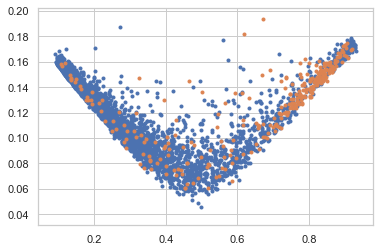

In [32]:
plt.scatter(probs[preds == y_test.squeeze().values], stds[preds == y_test.squeeze().values], marker='.')
plt.scatter(probs[preds != y_test.squeeze().values], stds[preds != y_test.squeeze().values], marker='.')

In [14]:
y_true = y_test.squeeze().values

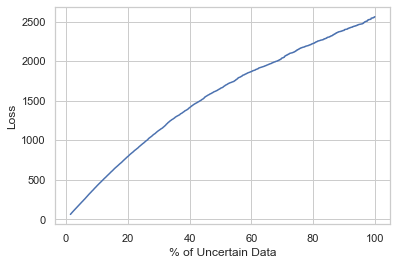

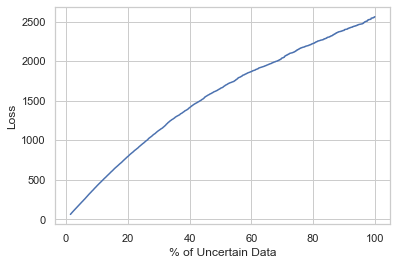

In [15]:
make_performance_uncertainty_plot(y_true, probs, stds, 'Loss', performance_fn_args={'reduction': 'sum'})

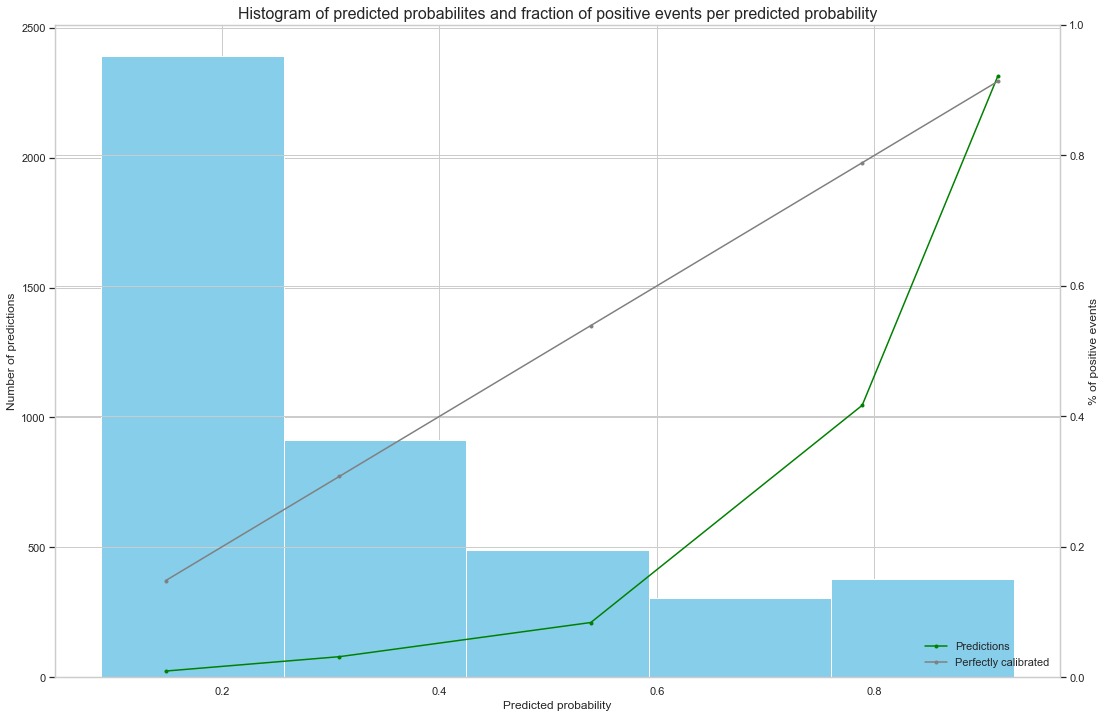

In [16]:
plot_calibration_curve(y_true, probs)

In [17]:
# loss at 100%
cross_entropy(y_true, probs, reduction='sum')

2561.3408630266786

In [18]:
# loss at 50%

y_50 = y_true[stds.argsort()[:int(0.5 * len(stds))]]
y_prob_50 = probs[stds.argsort()[:int(0.5 * len(stds))]]

cross_entropy(y_50, y_prob_50, reduction='sum')

1654.3927793204784

In [19]:
conf_intervals = np.clip(np.array([probs - 5 * stds,
           probs - 4 * stds,
           probs - 3 * stds,
           probs - 2 * stds,
           probs - 1 * stds,
           probs - 0 * stds,
           probs + 1 * stds,
           probs + 2 * stds,
           probs + 3 * stds,
           probs + 4 * stds,
           probs + 5 * stds]), 0, 1).T

In [ ]:
pred_intervals = np.array([probs - 5 * stds,
           probs - 4 * stds,
           probs - 3 * stds,
           probs - 2 * stds,
           probs - 1 * stds,
           probs - 0 * stds,
           probs + 1 * stds,
           probs + 2 * stds,
           probs + 3 * stds,
           probs + 4 * stds,
           probs + 5 * stds]) > cutoff
pred_intervals = pred_intervals.T.astype(int)

In [ ]:
(pred_intervals[:, 0:11] == np.repeat(y_true[:, None], 11, axis=1)).any(axis=1).mean()

In [ ]:
conf_intervals[:, 0].mean(), conf_intervals[:, 10].mean()

In [ ]:
(pred_intervals[:, 1:10] == np.repeat(y_true[:, None], 9, axis=1)).any(axis=1).mean()

In [ ]:
conf_intervals[:, 1].mean(), conf_intervals[:, 9].mean()

In [ ]:
(pred_intervals[:, 2:9] == np.repeat(y_true[:, None], 7, axis=1)).any(axis=1).mean()

In [ ]:
conf_intervals[:, 2].mean(), conf_intervals[:, 8].mean()

In [ ]:
(pred_intervals[:, 3:8] == np.repeat(y_true[:, None], 5, axis=1)).any(axis=1).mean()

In [ ]:
conf_intervals[:, 3].mean(), conf_intervals[:, 7].mean()

In [ ]:
(pred_intervals[:, 4:7] == np.repeat(y_true[:, None], 3, axis=1)).any(axis=1).mean()

In [ ]:
conf_intervals[:, 4].mean(), conf_intervals[:, 6].mean()

In [ ]:
(pred_intervals[:, 5:6] == np.repeat(y_true[:, None], 1, axis=1)).any(axis=1).mean()

In [ ]:
conf_intervals[:, 5].mean(), conf_intervals[:, 5].mean()